In [1]:
from functools import partial
import logging
from collections import OrderedDict

import numpy as np
from osgeo import gdal
%pylab inline
import matplotlib
import matplotlib.pyplot as plt

import proxmin
from proxmin import nmf
import dc

plogger = logging.getLogger("proxmin")
plogger.setLevel(logging.DEBUG)

points = OrderedDict([
    ("concrete", (162, 507)), # statue
    #("tar", (175, 546)), # road, degenerate with concrete
    #("shingles", (114, 575)), # roof, degenerate with dirt
    ("dirt", (172, 597)), # dirt
    ("grass", (125, 575)), #grass
    #("trees", (183, 561)), #tree
    ("bkg", (None,None))
])

#color_cycle = [dc.ref_colors[obj] for obj in points.keys()]
#matplotlib.rcParams['axes.color_cycle'] = color_cycle

Populating the interactive namespace from numpy and matplotlib


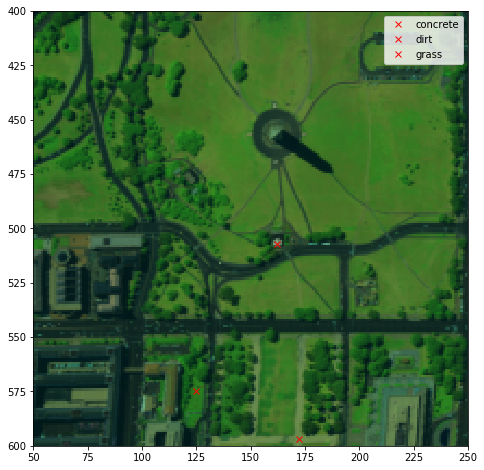

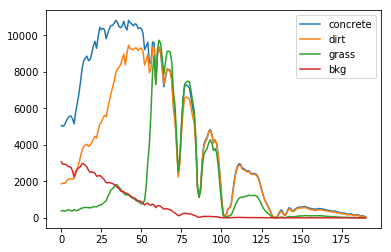

In [2]:
ds = gdal.Open('/Users/fred/Downloads/Hyperspectral_Project/dc.tif')
data_shape = ds.GetRasterBand(1).ReadAsArray().shape

# only use a subset of the image
shape = (ds.RasterCount, data_shape[0]*data_shape[1])

# Get hyperspectral data
data = np.zeros(shape)
for bidx in range(shape[0]):
    band = ds.GetRasterBand(bidx + 1).ReadAsArray()
    data[bidx] = band.flatten()
dc.plot_color_img(data, data_shape, figsize=(8,8), show=False);

# only use a subset of the image
xmin = 50
xmax = 250
ymin = 400
ymax = 600
img_shape = (ymax-ymin, xmax-xmin)
img = data.reshape(data.shape[0], data_shape[0], data_shape[1])[:,ymin:ymax, xmin:xmax]
img = img.reshape(data.shape[0], img_shape[0]*img_shape[1])

spectra = OrderedDict()
for obj, pt in points.items():
    if obj!="bkg":
        plt.plot(pt[0], pt[1],'rx', label=obj)
        spectra[obj] = dc.get_point_spec(pt[0], pt[1], data, data_shape)
    else:
        spectra[obj] = np.min(img, axis=1)

for obj, spec in spectra.items():
    if obj!="bkg":
        spectra[obj] = spec-spectra["bkg"]
plt.legend()
plt.xlim([50,250])
plt.ylim([600,400])
plt.show()

for obj, pt in points.items():
    plt.plot(spectra[obj], label=obj)
plt.legend()
plt.show()

# Get wavelengths used in hyperspectral data
wavelength_data = np.recfromcsv('/Users/fred/Downloads/Hyperspectral_Project/wavelengths.txt', delimiter=" ")
wavelength = wavelength_data["wavelength"]
idx = wavelength_data["idx"]

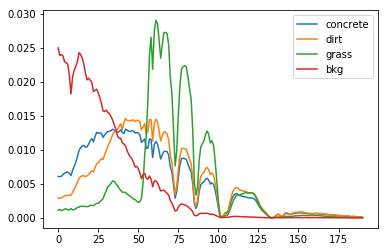

In [3]:
def init_nmf(img, img_shape, points, spec):
    """Initialize A0 and S0 using the reference points
    """
    features = len(points)
    A0 = np.zeros((img.shape[0], features))
    S0 = np.zeros((features, img_shape[0]*img_shape[1]))

    for idx, (obj,(x,y)) in enumerate(points.items()):
        A0[:, idx] = spec[obj]
    norm = np.sum(A0, axis=0)
    A0 = A0/norm
    for idx, (obj,(x,y)) in enumerate(points.items()):
        plt.plot(A0[:, idx], label=obj)
    plt.legend()
    plt.show()
    return A0, S0

A0,S0 = init_nmf(img, img_shape, points, spectra)
Ls = [[np.ones((1,A0.shape[0]))], [None]]

prox_A = proxmin.operators.prox_plus
prox_g = [[dc.prox_ones],[proxmin.operators.prox_id]]
#steps_g = [[1e-5],[None]]
#norm_L2 = [[np.array([50])], [1]]

In [4]:
import scipy.sparse
def prox_bkg(X, step, bidx=-1):
    """Use a constant background
    """
    X[bidx] = np.mean(X[bidx])
    return X

def prox_bkg_plus(X, step, bidx=-1):
    X = prox_bkg(X, step, bidx)
    X = proxmin.operators.prox_plus(X, step)
    return X

prox_g = partial(prox_bkg_plus, bidx=-1)

L = float(proxmin.utils.get_spectral_norm(A0))
print(L)
prox_S = partial(proxmin.nmf.prox_likelihood_S, A=A0, Y=img, prox_g=prox_g)
S0 = proxmin.algorithms.apgm(X0=S0, prox_f=prox_S, step_f=.5/L, max_iter=2)

INFO:proxmin.algorithms:Completed 2 iterations


0.03796682797280731


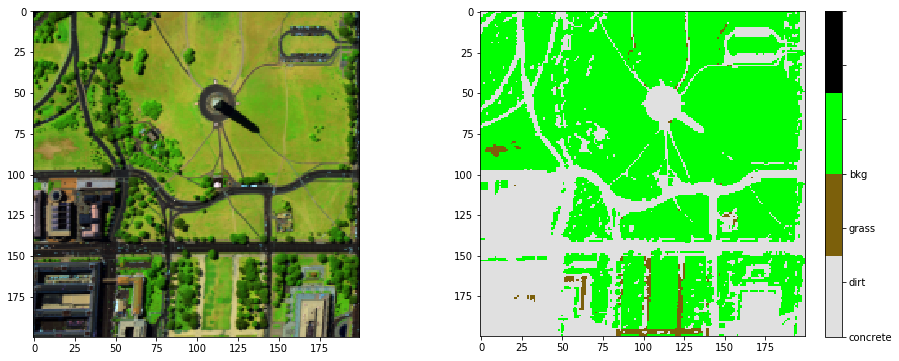

In [5]:
# Color associated with each reference object
ref_colors = {
    'grass': '#00ff00',
    'tar': '#07afc1',
    'shingles': '#bf4101',
    'concrete': '#e0e0e0',
    'dirt': '#7c600b',
    'trees': '#2c702c',
    'bkg': '#000000'
}

dc.compare_likelihood(img, img_shape, S0[:-1], points, figsize=(16,6), colors=ref_colors)

In [6]:
#Ls = [[None], [scipy.sparse.identity(A0.shape[1])]]
#prox_g = [[dc.prox_ones],[proxmin.operators.prox_id]]


Ls = [[np.ones((1,A0.shape[0]))], [None]]
prox_A = proxmin.operators.prox_plus
prox_S = partial(prox_bkg_plus, bidx=-1)
prox_g = [[dc.prox_ones],[proxmin.operators.prox_id]]

In [7]:
A, S = nmf.nmf(img,A0, S0,
                     prox_A=prox_A,
                     prox_S=prox_S,
                     Ls=Ls,
                     proxs_g=prox_g,
                     max_iter=1000, 
                     traceback=False,
                     #steps_g=steps_g
                     #norm_L2 = norm_L2
                     #slack=.1
                    )

INFO:proxmin.algorithms:Completed 1001 iterations


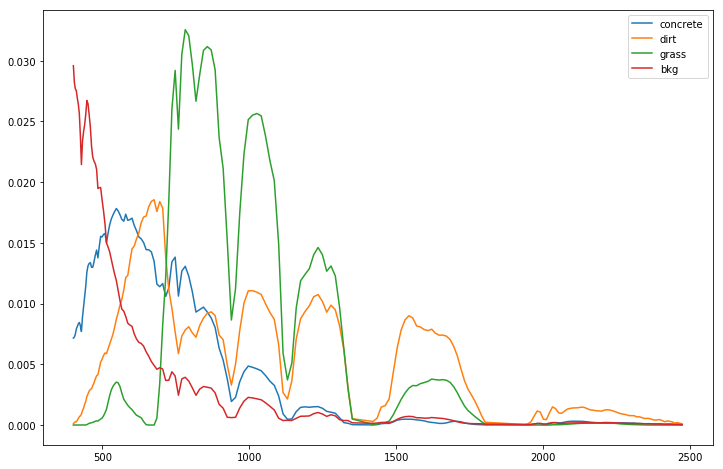

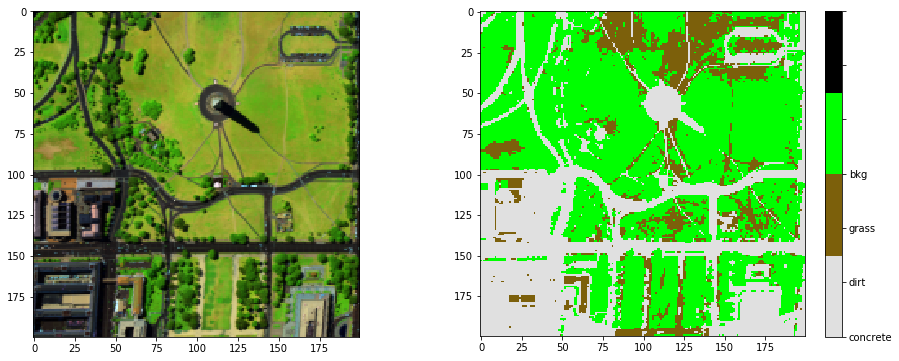

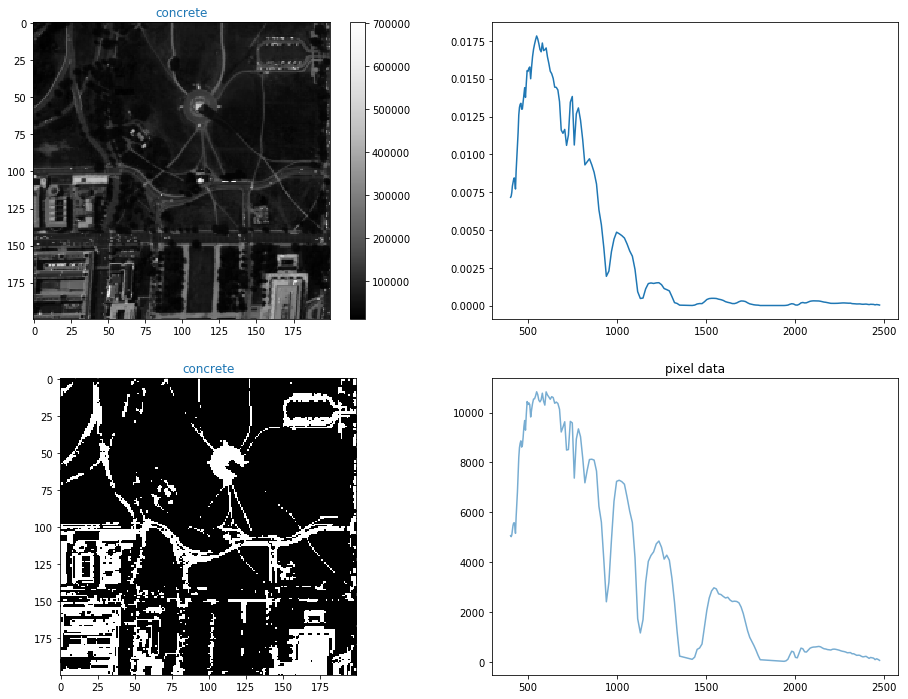

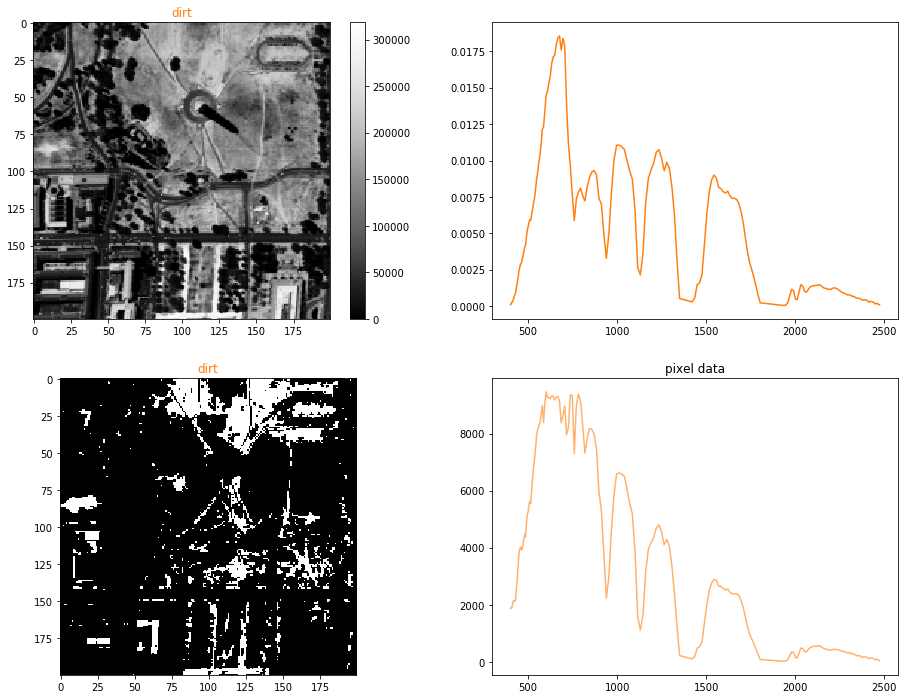

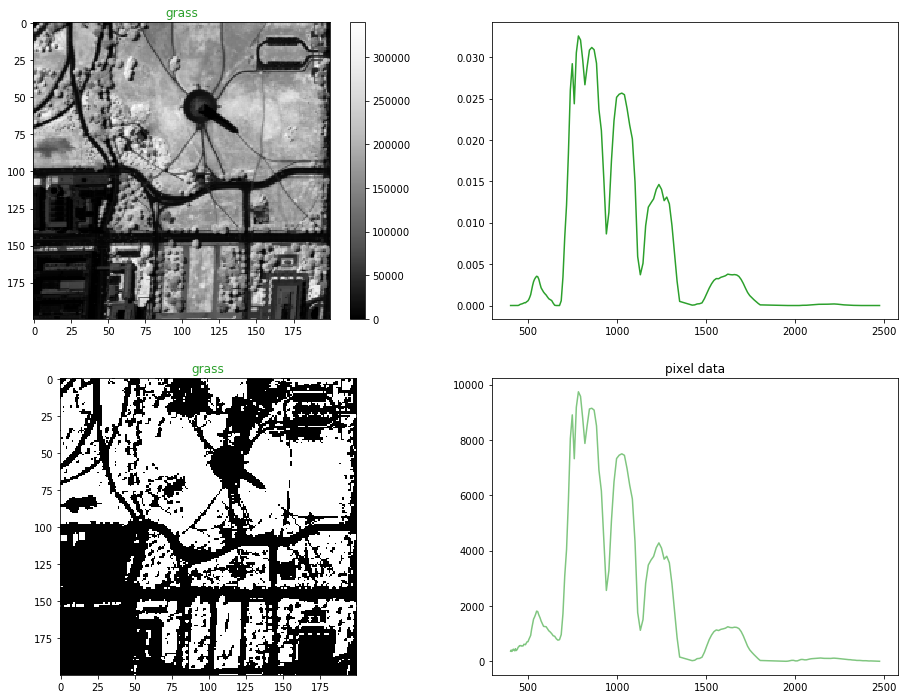

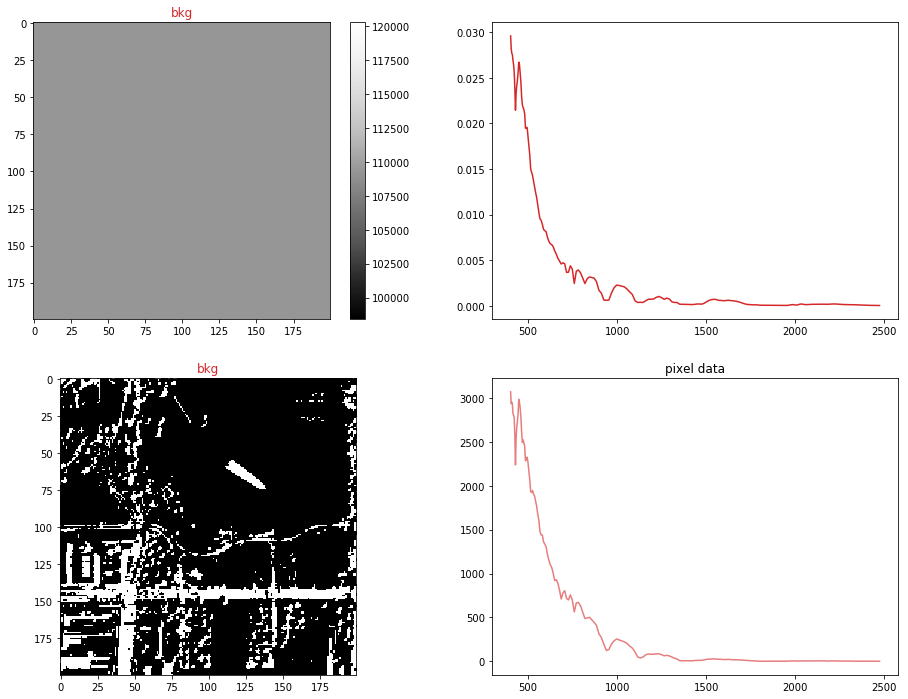

In [8]:
dc.plot_spectra(wavelength, A, points)
dc.compare_likelihood(img, img_shape, S[:-1], points, figsize=(16,6), colors=ref_colors)
dc.plot_objects(img, A, S, img_shape, points, spectra, wavelength=wavelength)

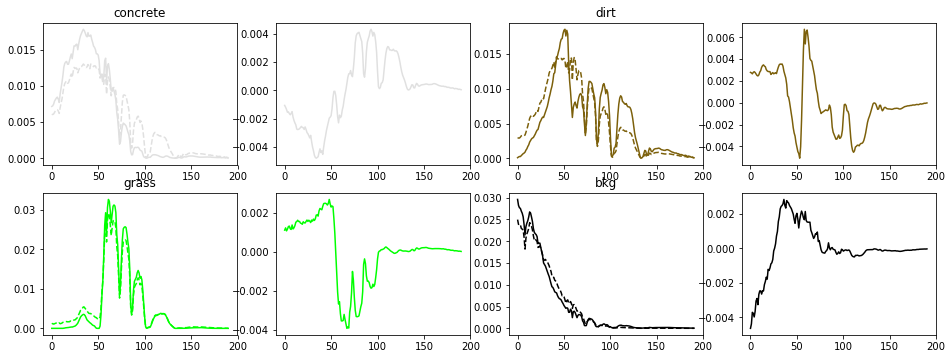

In [9]:
dA = A0-A

fig = plt.figure(figsize=(16,12))
for idx, (obj, pt) in enumerate(points.items()):
    ax1 = fig.add_subplot(4,4,2*idx+1)
    ax2 = fig.add_subplot(4,4,2*idx+2)
    ax1.set_title(obj)
    ax1.plot(A[:,idx], color=ref_colors[obj])
    ax1.plot(A0[:,idx], '--', color=ref_colors[obj])
    ax2.plot(dA[:,idx], color=ref_colors[obj])
plt.show()

In [10]:
def bounds(img, img_shape, data):
    # get the bounds of the data
    b = np.sum(data[:50], axis=0)
    g = np.sum(data[50:100], axis=0)
    r = np.sum(data[100:], axis=0)
    max_b = np.max(b)
    min_b = np.min(b)
    max_g = np.max(g)
    min_g = np.min(g)
    max_r = np.max(r)
    min_r = np.min(r)
    
    # Map spectra to RGB colors
    b = np.sum(img[:50], axis=0).reshape(img_shape)
    g = np.sum(img[50:100], axis=0).reshape(img_shape)
    r = np.sum(img[100:], axis=0).reshape(img_shape)
    # Set on a scale from 0-255
    b = b-min_b
    g = g-min_g
    r = r-min_r

    b = b/max_b
    g = g/max_g
    r = r/max_r
    return r,g,b

bkg_img = np.zeros_like(data)
for idx in range(A.shape[0]):
    bkg_img[idx, :] = A[idx, -1] * S[-1][0]

f = partial(bounds, data=data-bkg_img)

(191, 40000) (191, 4) (4, 40000)


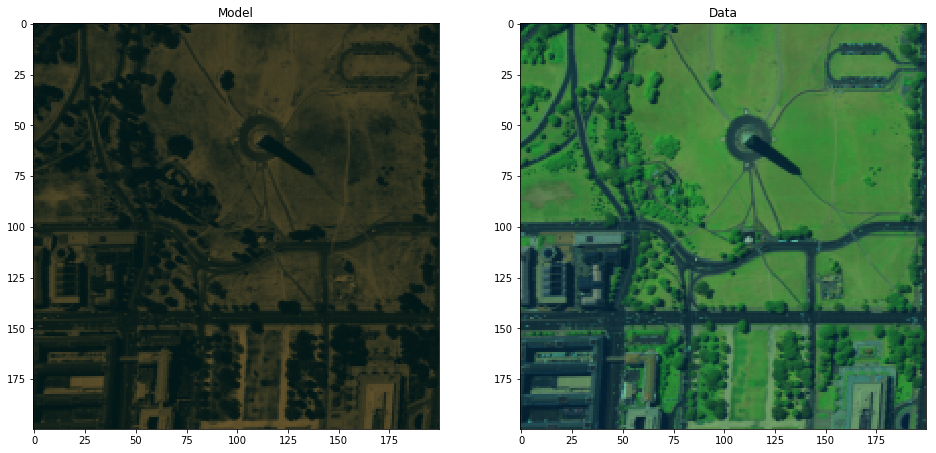

In [38]:
m = np.zeros_like(img)
print(m.shape, A.shape, S.shape)

features = [
    #"concrete",
    "dirt",
    #"grass",
    
    #"tar",
    #"shingles",
    #"trees"
]

for sidx in range(A.shape[0]):
    for feature in features:
        idx = list(points.keys()).index(feature)
        m[sidx, :] += A[sidx, idx] * S[idx]

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title("Model")
ax2 = fig.add_subplot(1,2,2)
ax2.set_title("Data")
dc.plot_color_img(m, img_shape, show=False, bounds=f, ax=ax1)
dc.plot_color_img(img, img_shape, show=True, bounds=f, ax=ax2)
plt.show()

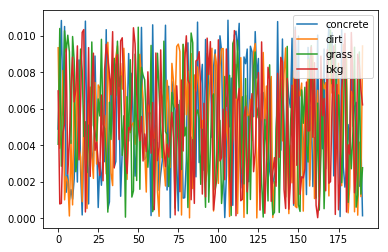

In [12]:
def init_nmf(img, img_shape, points, spec):
    """Initialize A0 and S0 using the reference points
    """
    features = len(points)
    A0 = np.random.rand(img.shape[0], features)
    S0 = np.random.rand(features, img_shape[0]*img_shape[1])

    norm = np.sum(A0, axis=0)
    A0 = A0/norm
    for idx, (obj,(x,y)) in enumerate(points.items()):
        plt.plot(A0[:, idx], label=obj)
    plt.legend()
    plt.show()
    return A0, S0

A0,S0 = init_nmf(img, img_shape, points, spectra)
Ls = [[np.ones((1,A0.shape[0]))], [None]]

prox_A = proxmin.operators.prox_plus
prox_g = [[dc.prox_ones],[proxmin.operators.prox_id]]
#steps_g = [[1e-5],[None]]
#norm_L2 = [[np.array([50])], [1]]

In [13]:
import scipy.sparse
def prox_bkg(X, step, bidx=-1):
    """Use a constant background
    """
    X[bidx] = np.mean(X[bidx])
    return X

def prox_bkg_plus(X, step, bidx=-1):
    X = prox_bkg(X, step, bidx)
    X = proxmin.operators.prox_plus(X, step)
    return X

prox_g = partial(prox_bkg_plus, bidx=-1)

L = float(proxmin.utils.get_spectral_norm(A0))
print(L)
prox_S = partial(proxmin.nmf.prox_likelihood_S, A=A0, Y=img, prox_g=prox_g)
S0 = proxmin.algorithms.apgm(X0=S0, prox_f=prox_S, step_f=.5/L, max_iter=2)

0.022597378031387186


INFO:proxmin.algorithms:Completed 2 iterations


In [14]:
#Ls = [[None], [scipy.sparse.identity(A0.shape[1])]]
#prox_g = [[dc.prox_ones],[proxmin.operators.prox_id]]


Ls = [[np.ones((1,A0.shape[0]))], [None]]
prox_A = proxmin.operators.prox_plus
prox_S = partial(prox_bkg_plus, bidx=-1)
prox_g = [[dc.prox_ones],[proxmin.operators.prox_id]]

Ar, Sr = nmf.nmf(img,A0, S0,
                     prox_A=prox_A,
                     prox_S=prox_S,
                     Ls=Ls,
                     proxs_g=prox_g,
                     max_iter=1000, 
                     traceback=False,
                     #steps_g=steps_g
                     #norm_L2 = norm_L2
                     #slack=.1
                    )

INFO:proxmin.algorithms:Completed 1001 iterations


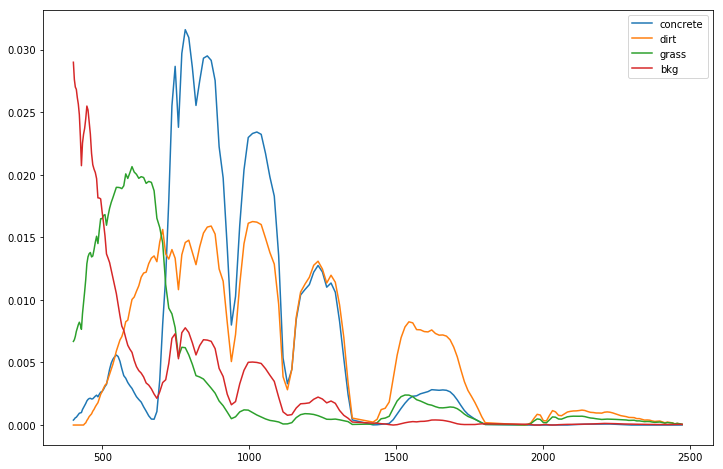

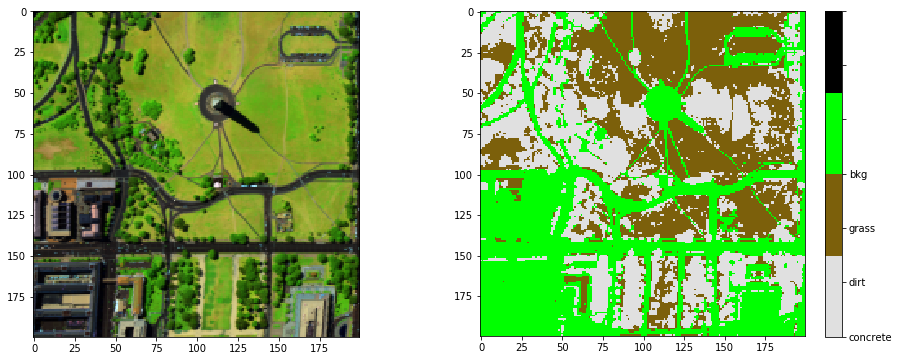

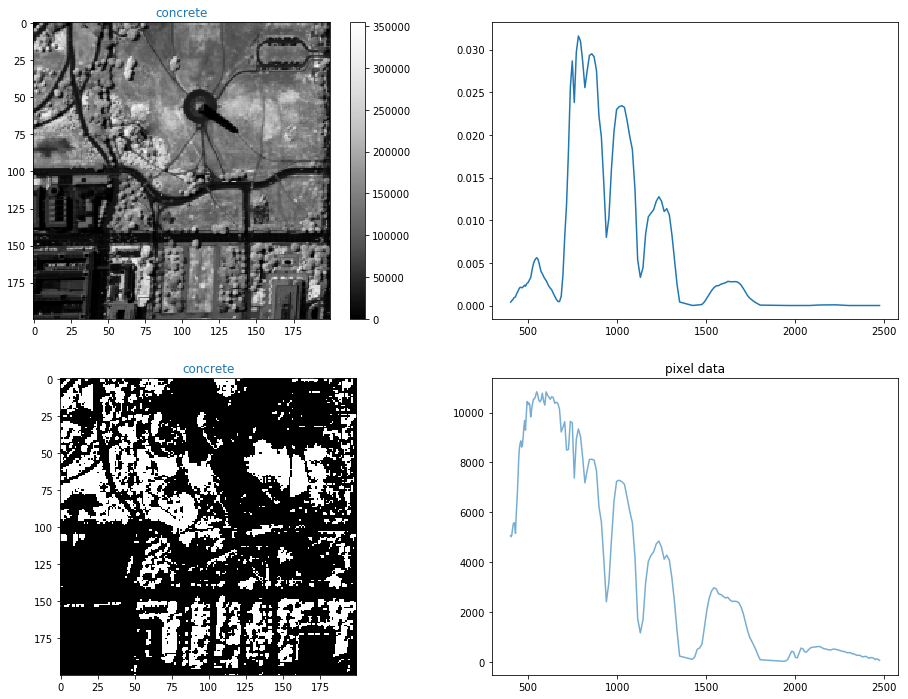

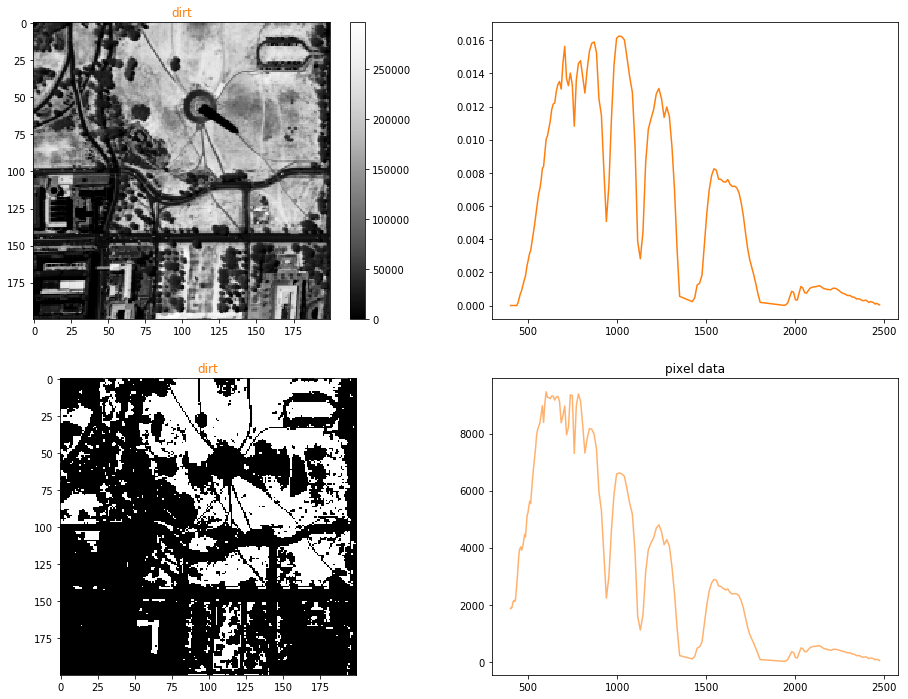

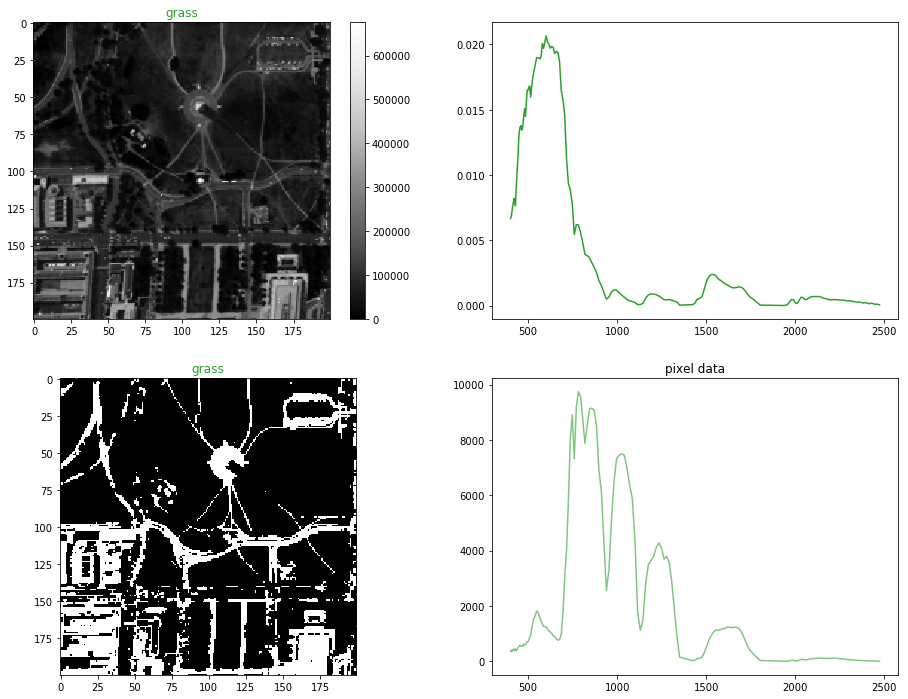

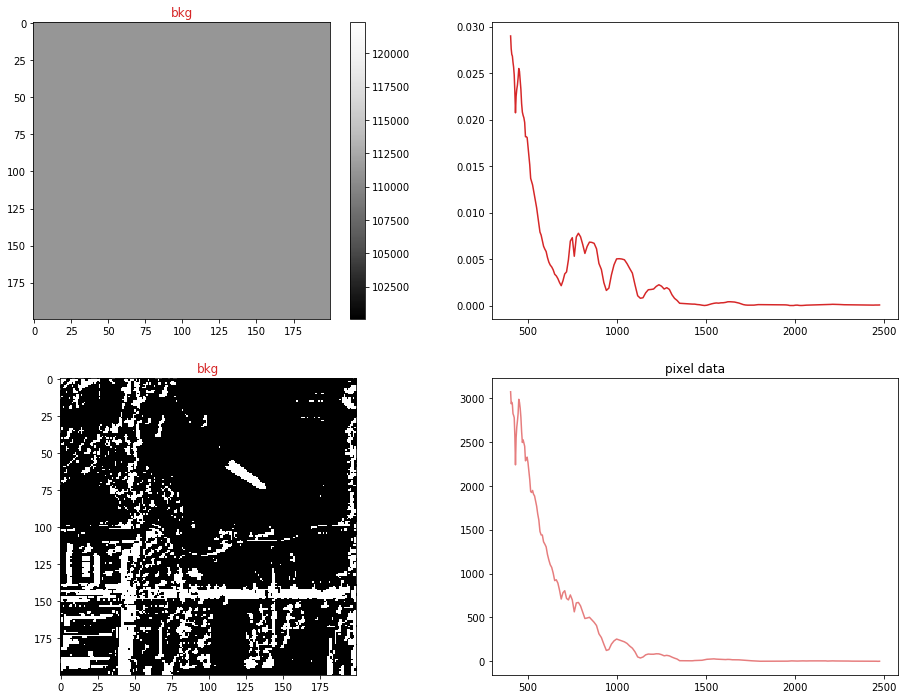

In [15]:
dc.plot_spectra(wavelength, Ar, points)
dc.compare_likelihood(img, img_shape, Sr[:-1], points, figsize=(16,6), colors=ref_colors)
dc.plot_objects(img, Ar, Sr, img_shape, points, spectra, wavelength=wavelength)

(191, 40000) (191, 4) (4, 40000)


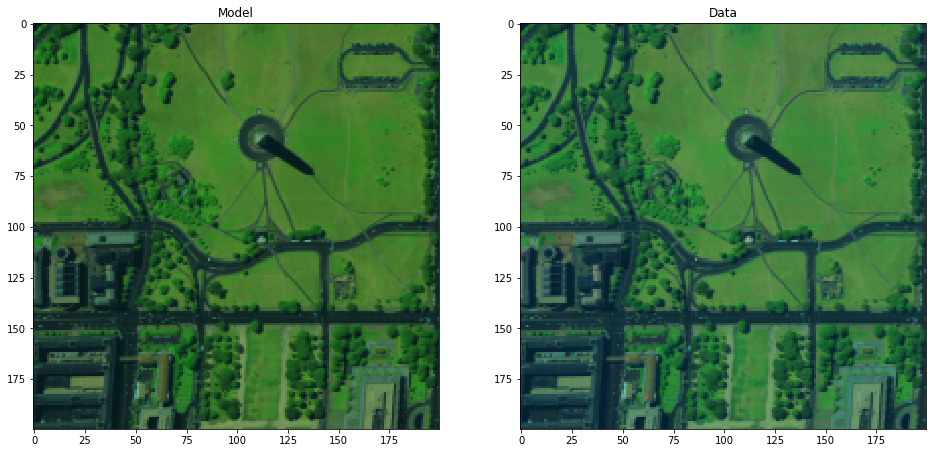

In [34]:
m = np.zeros_like(img)
print(m.shape, Ar.shape, Sr.shape)

features = [
    "concrete", #grass
    "dirt",
    "grass", #concrete
]

for sidx in range(Ar.shape[0]):
    for feature in features:
        idx = list(points.keys()).index(feature)
        m[sidx, :] += Ar[sidx, idx] * Sr[idx]

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title("Model")
ax2 = fig.add_subplot(1,2,2)
ax2.set_title("Data")
dc.plot_color_img(m, img_shape, show=False, bounds=f, ax=ax1)
dc.plot_color_img(img, img_shape, show=True, bounds=f, ax=ax2)
plt.show()